In [1]:
%%bash
git add my_toy_nn2.ipynb

In [140]:
%%bash
git commit -a -m "checkpoint"

[master 86444c8] checkpoint
 1 file changed, 247 insertions(+), 282 deletions(-)


In [ ]:
1+1

In [ ]:
%matplotlib inline

https://gist.github.com/santi-pdp/d0e9002afe74db04aa5bbff6d076e8fe

#  準備

* 正解がゼロとイチであるような100個のデータを作る
* ゼロの方よりイチのほうがすべての座標の平均が1.5大きい

In [143]:

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim


X1 = torch.randn(1000, 50)
X2 = torch.randn(1000, 50) + 1.5
X3 = torch.randn(1000,50) + 3
X = torch.cat([X1, X2 , X3], dim=0)
Y1 = torch.zeros(1000, 1)
Y2 = torch.ones(1000, 1)
Y3 = torch.zeros(1000 , 1)
Y = torch.cat([Y1, Y2, Y3], dim=0)
print(X.size())
print(Y.size())

torch.Size([3000, 50])
torch.Size([3000, 1])


In [144]:
import matplotlib.pyplot as plt
%matplotlib inline


In [145]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [146]:
ax1 = fig.add_subplot(111)

In [147]:
ax1.scatter(X1[:,0] , X1[:,2] , color = "yellow")

In [148]:
ax1.scatter(X2[:,0] , X2[:,2], color = "red")

In [149]:
ax1.scatter(X3[:,0] , X3[:,2] , color = "yellow")

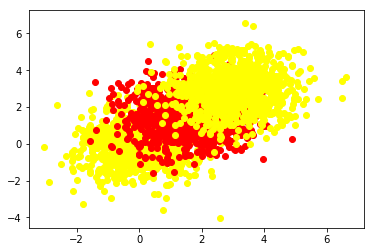

In [150]:
fig

In [21]:
X1.shape

torch.Size([1000, 50])

In [ ]:
Y1.shape

# ネットワークの定義

## main model


$    \text{PReLU}(x) = \max(0,x) + a * \min(0,x)$


In [151]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=50, out_features=50)
        self.relu1 = nn.ReLU()
        #self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        y = self.fc1(input_)
        y = self.relu1(y)        
        y = self.fc2(y)
        y = self.prelu(y)
        y = self.out(y)
        y = self.out_act(y)
        return y
    
    

## 線形変換 (値が0,1間に入らないのでcriteriaを評価できずエラーになる)

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 1)
        
    def forward(self, input_):
        y = self.fc1(input_)
        
        return y
    

##  線形変換＋sigmoid

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        y = self.out_act(a1)
        return y
    

## もともとのモデル

In [118]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(50, 50)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    

In [152]:
model = Net()

In [153]:
print(model)

Net(
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=100, bias=True)
  (prelu): PReLU(num_parameters=1)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


# optimizer

## 学習測度はここで指定する

learning rate次第で学習の成否が大きく異なってくる

In [154]:
opt = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))

# Binary cross entropy

ふたつの確率分布$p,q$があったときクロスエントロピーは

$$
H(p,q) =-{\rm E}_p[\log(q)]
$$

で定義される

説明変数のsample 
$$
x_0,x_1,\cdots , x_{N-1}
$$
に対して、正解が１であり、NNが確率$z$で１であると出力したとき、
正解の確率分布は


$$
 p(x) =
 \begin{cases}
        1 & x = 1\\
        0 & x = 0
 \end{cases}
$$
NNの導いた確率分布は
$$
 q(x) =
 \begin{cases}
        z & x = 1\\
        1-z & x = 0
 \end{cases}
$$
なのでクロスエントロピーは
$$
H(p,q) = -\log(z)
$$
であるが、
$$
H(q,p) = -z \log(1) - (1-z) \log(0)
$$
は計算できない

In [155]:
criterion = nn.BCELoss()

# my training

training modeに

In [157]:
model.train()

Net(
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=100, bias=True)
  (prelu): PReLU(num_parameters=1)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)

In [158]:
def yield_batch(X , Y , batch_size):
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :]
        y_batch = Y[beg_i:beg_i + batch_size, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        yield x_batch  ,y_batch
    

In [159]:
batch_size = 50

In [160]:
def my_one_epoch(model , opt, criterion, X , Y , batch_size):
    batch_iterator = yield_batch(X , Y  , batch_size)
    for x_batch , y_batch in batch_iterator:

        ## loop decomposed

        ### zero grad
        #毎回gradをクリアしないといけない

        opt.zero_grad()

        ### Forward

        y_hat = model(x_batch)

        ### Compute diff

        loss = criterion(y_hat, y_batch)
        #print("loss : {}".format(loss))

        ### Compute gradients

        loss.backward()

        ### update weights

        opt.step()        

        ### loss 

        run_loss = float(loss.data.numpy())

    print(run_loss)

In [163]:
n_epochs = 20
for i in range(n_epochs):
    my_one_epoch(model , opt, criterion, X , Y , batch_size)

0.3051535487174988
0.30128970742225647
0.2972703278064728
0.2929415702819824
0.28843235969543457
0.28390446305274963
0.2792169451713562
0.27442580461502075
0.269666463136673
0.26501595973968506
0.26033419370651245
0.25536900758743286
0.25043851137161255
0.24568960070610046
0.2409067302942276
0.23596012592315674
0.23116269707679749
0.2263917475938797
0.221628338098526
0.21682383120059967


#  答え合わせ

In [164]:
y_model = model(X)

In [165]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [166]:
ax1 = fig.add_subplot(111)

In [167]:
Y.numpy()[:,0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [168]:
ax1.scatter(Y.numpy()[:,0] , y_model.detach().numpy()[:,0] , color = "red")

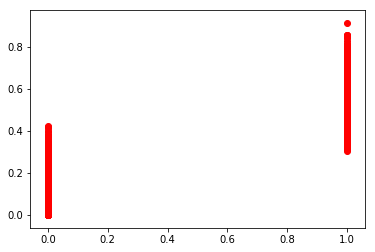

In [169]:
fig

In [99]:
tmp = y_model.detach().numpy()

In [100]:
tmp.summary()

AttributeError: 'numpy.ndarray' object has no attribute 'summary'

# decomposed training

In [125]:
batch_iterator = yield_batch(X , Y  , batch_size)

In [46]:
x_batch , y_batch = next(batch_iterator)

## loop decomposed

### zero grad
毎回gradをクリアしないといけない

In [47]:
opt.zero_grad()

### Forward

In [48]:
y_hat = model(x_batch)

### Compute diff

In [50]:
loss = criterion(y_hat, y_batch)
print("loss : {}".format(loss))

loss : 0.7317055463790894


### Compute gradients

In [ ]:
loss.backward()

### update weights

In [ ]:
opt.step()        

### loss 

In [ ]:
run_loss = float(loss.data.numpy())

print(run_loss)

# original

def train_epoch(model, opt, criterion, batch_size=50):
    model.train()
    losses = []
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :]
        y_batch = Y[beg_i:beg_i + batch_size, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)


        opt.zero_grad()
        # (1) Forward
        y_hat = net(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

In [ ]:
e_losses = []
num_epochs = 200
for e in range(num_epochs):
    e_losses += train_epoch(net, opt, criterion)
plt.plot(e_losses)

In [ ]:
?Variable

In [ ]:
batch_size = 50

In [ ]:
losses = []
for beg_i in range(0, X.size(0), batch_size):
    x_batch = X[beg_i:beg_i + batch_size, :]
    y_batch = Y[beg_i:beg_i + batch_size, :]
    x_batch = Variable(x_batch)
    y_batch = Variable(y_batch)

    opt.zero_grad()
    # (1) Forward
    y_hat = net(x_batch)
    # (2) Compute diff
    loss = criterion(y_hat, y_batch)
    # (3) Compute gradients
    loss.backward()
    # (4) update weights
    opt.step()        
    losses.append(loss.data.numpy())

In [ ]:
loss.backward?

In [ ]:
plt.plot(losses)

In [ ]:
print(losses)

In [ ]:
train_epoch(net, opt, criterion)